# CS 229 Final Project

Authors: Imogen Gardiner, Zofia Dudek, Galen Topper

## Project Overview:

Our project involves building machine learning models to improve the prediction of progression of breast cancer.

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import roc_auc_score, mean_squared_error
import numpy as np
#from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

#from utils import datasets, train_and_eval_model, run_hparam_search


#### Processing the data

In [2]:
# Read in the dataset
bc_data = pd.read_csv('breast_msk_2018_clinical_data.tsv', sep='\t') 
cnv_df = pd.read_csv("breast_msk_2018_segments.seg", sep="\t") 
print(bc_data.head())
print(cnv_df.head())
# change

          Study ID Patient ID          Sample ID    Cancer Type  \
0  breast_msk_2018  P-0000004  P-0000004-T01-IM3  Breast Cancer   
1  breast_msk_2018  P-0000012  P-0000012-T02-IM3  Breast Cancer   
2  breast_msk_2018  P-0000015  P-0000015-T01-IM3  Breast Cancer   
3  breast_msk_2018  P-0000041  P-0000041-T01-IM3  Breast Cancer   
4  breast_msk_2018  P-0000057  P-0000057-T01-IM3  Breast Cancer   

                        Cancer Type Detailed  Disease Free Event  \
0           Breast Invasive Ductal Carcinoma                   1   
1           Breast Invasive Ductal Carcinoma                   0   
2           Breast Invasive Ductal Carcinoma                   1   
3           Breast Invasive Ductal Carcinoma                   1   
4  Breast Mixed Ductal and Lobular Carcinoma                   1   

   Disease Free (Months) ER PCT Primary ER Status of Sequenced Sample  \
0                    1.1             70                      Positive   
1                  218.0              0   

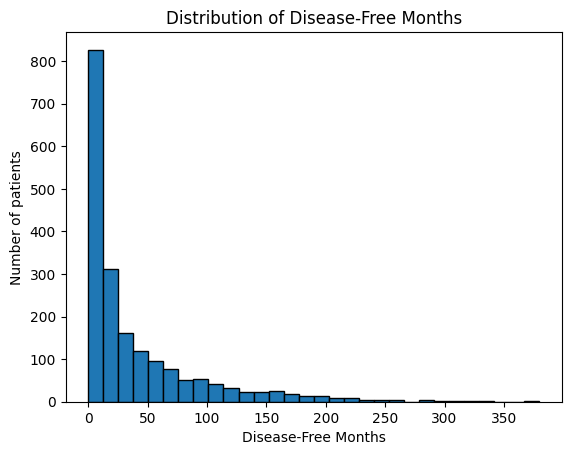

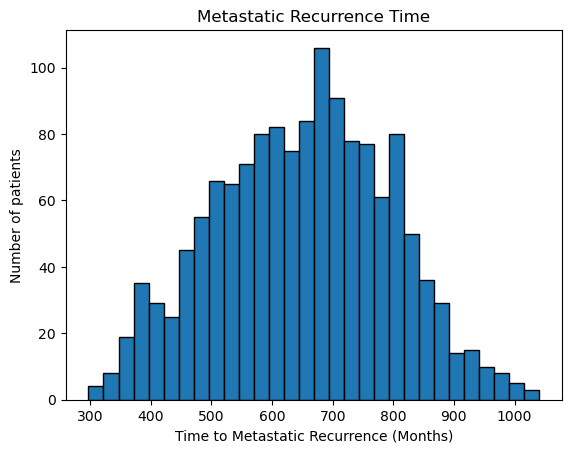

In [3]:
# Visualize the data

# Disease-free months
plt.hist(bc_data['Disease Free (Months)'], bins=30, edgecolor='black')
plt.xlabel('Disease-Free Months')
plt.ylabel('Number of patients')
plt.title('Distribution of Disease-Free Months')
plt.show()

# Metastatic recurrence time
plt.hist(bc_data['Metastatic Recurrence Time'], bins=30, edgecolor='black')
plt.xlabel('Time to Metastatic Recurrence (Months)')
plt.ylabel('Number of patients')
plt.title('Metastatic Recurrence Time')
plt.show()


In [12]:
# Split data into train, valid, test sets

train_idx, valid_idx, test_idx = None, None, None 

train_idx, test_idx = train_test_split(bc_data.index, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)

NameError: name 'bc_data' is not defined

In [5]:
# Now, split up features and labels
ds_instance = datasets(
    train_X = bc_data.loc[train_idx],
    valid_X = bc_data.loc[valid_idx],
    test_X = bc_data.loc[test_idx],
    train_y = bc_data.loc[train_idx, "Metastatic Recurrence Time"],
    valid_y = bc_data.loc[valid_idx, "Metastatic Recurrence Time"],
    test_y = bc_data.loc[test_idx, "Metastatic Recurrence Time"],
    )

# Preprocess the data

#### Training a linear regression model

In [11]:
# Extract genomic features
# Constants
TOTAL_GENOME_LENGTH = 3_200_000_000  # Approximate human genome size in base pairs

# Extract Total number of segments per sample
segments_per_sample = cnv_df.groupby("ID").size().reset_index(name="total_segments")

# Compute Proportion of genome affected per sample
cnv_df["segment_length"] = cnv_df["loc.end"] - cnv_df["loc.start"]
cnv_affected_length = cnv_df.groupby("ID")["segment_length"].sum().reset_index()
cnv_affected_length["proportion_genome_affected"] = cnv_affected_length["segment_length"] / TOTAL_GENOME_LENGTH

# Compute Mean CNV per chromosome per sample
mean_cnv_per_chromosome = cnv_df.groupby(["ID", "chrom"])["seg.mean"].mean().unstack().reset_index()
mean_cnv_per_chromosome.columns = ["ID"] + [f"mean_cnv_chr{c}" for c in mean_cnv_per_chromosome.columns[1:]]


# Merge extracted features
genomic_features = segments_per_sample

genomic_features = genomic_features.merge(cnv_affected_length[["ID", "proportion_genome_affected"]], on="ID")
genomic_features = genomic_features.merge(mean_cnv_per_chromosome, on="ID")

# Merge with clinical table
merged_data = bc_data.merge(genomic_features, left_on="Sample ID", right_on="ID", how="left").drop(columns=["ID"])

# Save the merged dataset
merged_data.to_csv("merged_clinical_genomic_data.csv", index=False)

# Display results
print(merged_data.head())

NameError: name 'cnv_df' is not defined

In [9]:
# Select only the mean_cnv_chr columns
mean_cnv_columns = merged_data.filter(like="mean_cnv_chr")

# Set up the figure
plt.figure(figsize=(12, 6))

# Loop through each column and plot its proportion of NaN vs. filled values
for column in mean_cnv_columns.columns:
    nan_count = mean_cnv_columns[column].isna().sum()
    filled_count = mean_cnv_columns[column].notna().sum()
    total = nan_count + filled_count

    # Bar chart for each feature
    plt.bar(column, filled_count / total, color="blue", label="Filled Values" if column == mean_cnv_columns.columns[0] else "")
    plt.bar(column, nan_count / total, bottom=filled_count / total, color="red", label="NaN Values" if column == mean_cnv_columns.columns[0] else "")

# Formatting
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.xlabel("Chromosome Feature")
plt.ylabel("Proportion of Values")
plt.title("Proportion of NaN vs. Filled Values for Each Mean CNV per Chromosome Feature")
plt.legend()
plt.show()

NameError: name 'merged_data' is not defined

### Linear Regression Model

In [7]:
y = merged_data["Metastatic Recurrence Time"].dropna() 
X = merged_data

# Remove the target variable from features
X = X.drop(columns=["Metastatic Recurrence Time"], errors="ignore")

# Align X and y
X = X.loc[y.index].reset_index(drop=True) 
y = y.reset_index(drop=True)

# Encode categorical variables
categorical_columns = X.select_dtypes(include=["object"]).columns
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X[categorical_columns] = encoder.fit_transform(X[categorical_columns])

# Ensure all remaining features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Features (remove unnecessary columns),
X = X.drop(columns=["Metastatic Disease at Last Follow-up", #overlap with target
"Study ID", "Patient ID", "Sample ID", # IDs not useful for prediction
"Last Communication Contact", # Metadata
#"Patient's Vital Status", # More of an outcome variable than predictive feature and may overlap with target "Somatic Status"
"Number of Samples Per Patient", # No direct predictive value, could introduce noise
"NGS Sample Collection Time Period", # Logisitcal metadata
"Overall Survival (Months)", # More of an outcome variable than predictive feature, may overlap with "Overall Survival Status"
"Time To Death (Months)", # Outcome feature and potential overlap with target
"mean_cnv_chrX" # Mostly Nan values
])

# Define function to perform hyperparameter tuning for linear regression using GridSearchCV
def hyperparameter_search_linear(X_train, y_train, param_grid, inner_cv):
    model = Pipeline([
        ("scaler", StandardScaler()),  
        ("feature_selection", SelectKBest(score_func=f_regression)),  
        ("regressor", Ridge())  # Default to Ridge, change to Lasso if needed
    ])

    search = GridSearchCV(model, param_grid, cv=inner_cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
    search.fit(X_train, y_train)

    return {"best_params": search.best_params_, "best_score": -search.best_score_} # convert negative RMSE to RMSE

param_grid = {
    "feature_selection__k": [10, 15, 20, 25, 30, 35, 40, 45, 50, 55],  
    "regressor": [Ridge(), Lasso(alpha=10, max_iter=5000)],  
    "regressor__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]  
}

hyperparam_results = {}  # Dictionary to store RMSE for (k, alpha) pairs

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_train_scores = []
rmse_test_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ensure all values are numeric
    X_train = pd.DataFrame(X_train).apply(pd.to_numeric, errors='coerce')
    X_test = pd.DataFrame(X_test).apply(pd.to_numeric, errors='coerce')
    y_train = pd.to_numeric(y_train, errors='coerce')

    # Perform mean imputation of missing values
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Convert back to df 
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

    # Apply mean imputation to the target variable
    y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Conduct hyperparameter tuning using inner cross-validation
    search_results = hyperparameter_search_linear(X_train, y_train, param_grid, inner_cv=5)
    best_params = search_results["best_params"]
    print(f"Best Params (Inner CV): {best_params}, Best Validation RMSE: {search_results['best_score']:.4f}")

    # Use SelectKBest with best k found during hyperparameter search
    selector = SelectKBest(score_func=f_regression, k=best_params["feature_selection__k"])
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_features = X.columns[selector.get_support()]
    print(f"Top {best_params['feature_selection__k']} selected features: {list(selected_features)}")

    # Train model with best hyperparameters from search
    best_model = best_params["regressor"].set_params(alpha=best_params["regressor__alpha"])
    best_model.fit(X_train_selected, y_train)

    # Predict on selected features
    y_train_pred = best_model.predict(X_train_selected)
    y_test_pred = best_model.predict(X_test_selected)

    # Evaluate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_train_scores.append(train_rmse)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_test_scores.append(test_rmse)

    # Store RMSE in dict
    hyperparam_results[(best_params["feature_selection__k"], best_params["regressor__alpha"])] = test_rmse

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    
# Report final results
print(f"Mean Train RMSE: {np.mean(rmse_train_scores):.4f}")
print(f"Mean Test RMSE: {np.mean(rmse_test_scores):.4f}")

NameError: name 'merged_data' is not defined

Plot linear regression model 

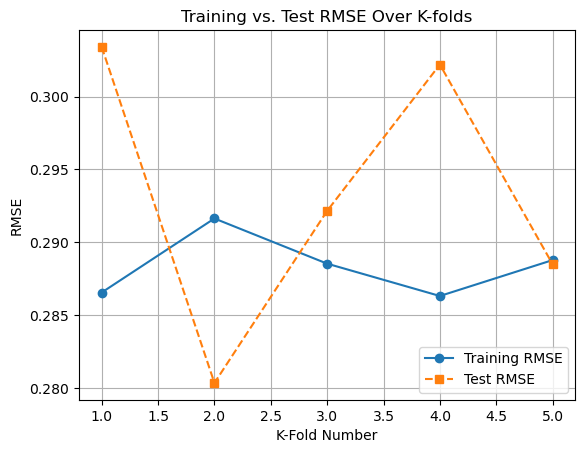

In [16]:
# Create an iteration index (e.g., fold numbers)
iterations = range(1, len(rmse_train_scores) + 1)

# Plot Training RMSE
plt.plot(iterations, rmse_train_scores, label="Training RMSE", marker='o', linestyle='-')

# Plot Test RMSE
plt.plot(iterations, rmse_test_scores, label="Test RMSE", marker='s', linestyle='--')

# Formatting the plot
plt.xlabel("K-Fold Number")
plt.ylabel("RMSE")
plt.title("Training vs. Test RMSE Over K-folds")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Plot hyperparameter tuning results

/var/folders/q0/j9yz0h6s7g1cm7slf4lg5xsm0000gn/T/ipykernel_98702/727157541.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores_sorted.values, y=feature_scores_sorted.index, palette="viridis")


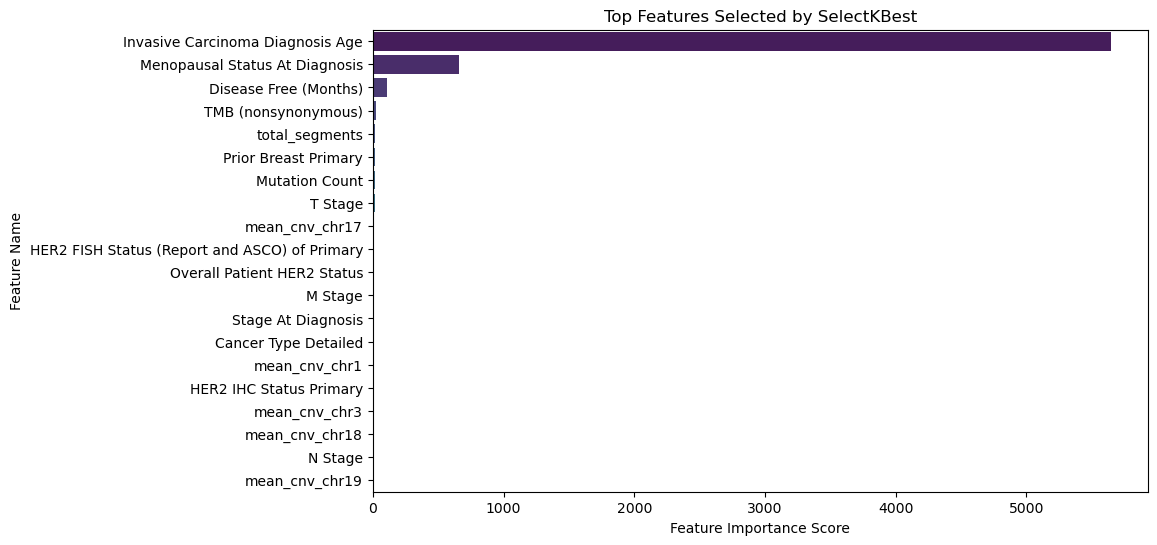

In [14]:
# Convert feature selection results into a dictionary
feature_scores = pd.Series(selector.scores_, index=X.columns)

# Sort features by importance
feature_scores_sorted = feature_scores.nlargest(20)  # Show top 20 features

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_scores_sorted.values, y=feature_scores_sorted.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top Features Selected by SelectKBest")
plt.show()


#### Training an XGBoost model
We have many missing values, which XGBoost can handle well.

Metrics: {'train': 0.45185138266888114, 'valid': 92.33603284407312, 'test': 86.9274697431041}


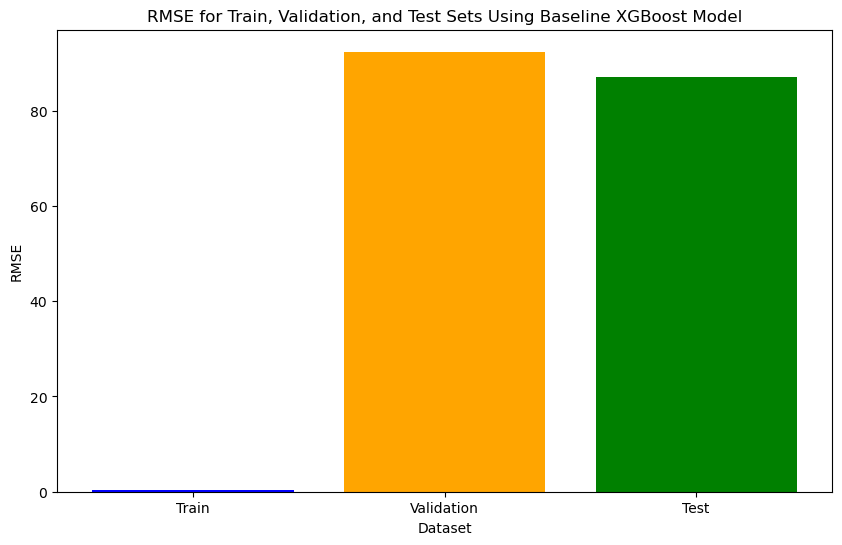

In [17]:
# Handle categorical features
categorical_features = ds_instance.train_X.select_dtypes(include=["object"]).columns

for col in categorical_features:
    ds_instance.train_X[col] = ds_instance.train_X[col].astype("category")
    ds_instance.valid_X[col] = ds_instance.valid_X[col].astype("category")
    ds_instance.test_X[col] = ds_instance.test_X[col].astype("category")

# Define XGBoost model
XGB_model = XGBRegressor(random_state=0, n_estimators=100, learning_rate=0.1, max_depth=5, enable_categorical=True)

# Define features to include 
features_to_include = ["Cancer Type", "Cancer Type Detailed", "Disease Free Event", "Disease Free (Months)", "ER PCT Primary", 
                       "ER Status of Sequenced Sample", "ER Status of the Primary", "Fraction Genome Altered", "HER2 FISH Status of Sequenced Sample", 
                       "HER2 FISH Ratio Value of Sequenced Sample", "HER2 FISH Ratio Primary", "HER2 FISH Status (Report and ASCO) of Primary", 
                       "HER2 IHC Status Primary", "HER2 IHC Score of Sequenced Sample", "HER2 IHC Status of Sequenced Sample", "HER2 IHC Score Primary", 
                       "HER2 Primary Status", "Overall HR Status of Sequenced Sample", "Invasive Carcinoma Diagnosis Age", 
                       "Time to Diagnosis Invasive Carcinoma", "Last Communication Contact", "Primary Tumor Laterality", "M Stage", 
                       "Menopausal Status At Diagnosis", "Metastatic Disease at Last Follow-up", "Mutation Count", 
                       "N Stage", "NGS Sample Collection Time Period", "Oncotree Code", "Overall Survival (Months)", "Overall Survival Status", 
                       "Overall HER2 Status of Sequenced Sample", "Overall Patient HER2 Status", "Overall Patient HR Status", 
                       "Overall Patient Receptor Status", "Overall Primary Tumor Grade", "PR PCT Primary", "PR Status of Sequenced Sample", 
                       "PR Status of the Primary", "Primary Nuclear Grade", "Prior Breast Primary", "Prior Local Recurrence", "Receptor Status Primary", 
                       "Number of Samples Per Patient", "Site of Sample", "Sample Type", "Sex", "Somatic Status", "Stage At Diagnosis", "T Stage", 
                       "Time To Death (Months)", "TMB (nonsynonymous)", "Tumor Sample Histology", "Tumor Tissue Origin", "Patient's Vital Status"]

# Remove rows with NaN values in the features to include
ds_instance.train_X = ds_instance.train_X[features_to_include].dropna()
ds_instance.valid_X = ds_instance.valid_X[features_to_include].dropna()
ds_instance.test_X = ds_instance.test_X[features_to_include].dropna()

# Ensure the target variable has no NaN values
ds_instance.train_y = ds_instance.train_y[ds_instance.train_X.index]
ds_instance.valid_y = ds_instance.valid_y[ds_instance.valid_X.index]
ds_instance.test_y = ds_instance.test_y[ds_instance.test_X.index]

# Train and evaluate XGBoost model
predictions, metrics = train_and_eval_model(model=XGB_model, ds=ds_instance, features_to_include=features_to_include)

# Report metrics
print("Metrics:", metrics)

# Plot metrics
# Extract the metrics
train_rmse = metrics['train']
valid_rmse = metrics['valid']
test_rmse = metrics['test']

# Create a bar plot
labels = ['Train', 'Validation', 'Test']
rmse_values = [train_rmse, valid_rmse, test_rmse]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_values, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('RMSE')
plt.title('RMSE for Train, Validation, and Test Sets Using Baseline XGBoost Model')
plt.show()

#### Addressing overfitting
To address overfitting, we will run a hyperparameter search and retrain the model on the best hyperparameters found.

In [36]:
from utils import run_hparam_search

# Remove categorical features from the dataset (TODO: figure out how to handle categorical features)
ds_instance.train_X = ds_instance.train_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.valid_X = ds_instance.valid_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.test_X = ds_instance.test_X.select_dtypes(include=["int", "float", "bool"])

# Update features_to_include to only include numerical features
features_to_include = ds_instance.train_X.columns.tolist()

print(len(features_to_include))

import xgboost
print(xgboost.__version__)

# Run a hyperparameter search
best_metrics, best_params = run_hparam_search(ds=ds_instance, features_to_include=features_to_include, max_depth_options=[1, 2, 3], 
                                              learning_rate_options=[0.001, 0.01, 0.1, 0.2, 0.3], n_estimators_options=[2, 5, 10, 25, 50])

# Report best hyperparameters and model performance
print("Best Hyperparameters Found:", best_params)
print("Best Metrics Found:", best_metrics)


12
2.1.1


TypeError: xgboost.sklearn.XGBRegressor() got multiple values for keyword argument 'enable_categorical'

#### Training a Random Survival Forest Model


In [6]:
#### Training Survival and Classification Models for Cancer Outcomes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.calibration import calibration_curve

# Define features to include
# features_to_include = [
#     "Cancer Type", "Cancer Type Detailed", "Disease Free Event", "Disease Free (Months)", "ER PCT Primary", 
#     "ER Status of Sequenced Sample", "ER Status of the Primary", "Fraction Genome Altered", "HER2 FISH Status of Sequenced Sample", 
#     "HER2 FISH Ratio Value of Sequenced Sample", "HER2 FISH Ratio Primary", "HER2 FISH Status (Report and ASCO) of Primary", 
#     "HER2 IHC Status Primary", "HER2 IHC Score of Sequenced Sample", "HER2 IHC Status of Sequenced Sample", "HER2 IHC Score Primary", 
#     "HER2 Primary Status", "Overall HR Status of Sequenced Sample", "Invasive Carcinoma Diagnosis Age", 
#     "Time to Diagnosis Invasive Carcinoma", "Last Communication Contact", "Primary Tumor Laterality", "M Stage", 
#     "Menopausal Status At Diagnosis", "Mutation Count", 
#     "N Stage", "NGS Sample Collection Time Period", "Oncotree Code", "Overall Survival (Months)", 
#     "Overall HER2 Status of Sequenced Sample", "Overall Patient HER2 Status", "Overall Patient HR Status", 
#     "Overall Patient Receptor Status", "Overall Primary Tumor Grade", "PR PCT Primary", "PR Status of Sequenced Sample", 
#     "PR Status of the Primary", "Primary Nuclear Grade", "Prior Breast Primary", "Prior Local Recurrence", "Receptor Status Primary", 
#     "Number of Samples Per Patient", "Site of Sample", "Sample Type", "Sex", "Somatic Status", "Stage At Diagnosis", "T Stage", 
#     "TMB (nonsynonymous)", "Tumor Sample Histology", "Tumor Tissue Origin"
# ]


data = pd.read_csv('merged_clinical_genomic_data.csv', sep='\t')

### PART 1: OVERALL SURVIVAL PREDICTION (SURVIVAL ANALYSIS)

y_os = np.array(
    [(str(status).strip().lower() == "deceased", float(time))
     for status, time in zip(data["Patient's Vital Status"], data["Overall Survival (Months)"])],
    dtype=[("event", "bool"), ("time", "float")]
)
valid_os_indices = ~np.isnan(data["Overall Survival (Months)"])
y_os = y_os[valid_os_indices]
data_os = data.loc[valid_os_indices]

X_os = data_os[features_to_include]

X_os = pd.get_dummies(X_os, drop_first=True)
X_os = X_os.fillna(X_os.median())
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size=0.2, random_state=42)

random_forest_os = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
random_forest_os.fit(X_train_os, y_train_os)

c_index_os = concordance_index_censored(y_test_os["event"], y_test_os["time"], random_forest_os.predict(X_test_os))
print(f"Overall Survival - Concordance index: {c_index_os[0]:.3f}")

test_pred_os = random_forest_os.predict(X_test_os)
risk_scores_os = pd.Series(test_pred_os)
risk_groups_os = pd.qcut(risk_scores_os, 3, labels=['Low Risk', 'Medium Risk', 'High Risk'])

plt.figure(figsize=(12, 6))
times = np.arange(0, 120, 0.5)

for risk_group in ['Low Risk', 'Medium Risk', 'High Risk']:
    indices = np.where(risk_groups_os == risk_group)[0]
    
    if len(indices) > 0:
        sample_idx = indices[0]
        patient_features = X_test_os.iloc[sample_idx:sample_idx+1]
        
        survival_func = random_forest_os.predict_survival_function(patient_features)[0]
        survival_probs = survival_func(times)
        
        plt.plot(times, survival_probs, label=f"{risk_group}")

plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title('Overall Survival Curves for Different Risk Groups')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### PART 2: METASTASIS PREDICTION (BINARY CLASSIFICATION)
data['metastasis_binary'] = data["Metastatic Disease at Last Follow-up"].map(
    lambda x: 1 if str(x).strip().lower() == "yes" else 0
)

valid_met_indices = ~data['metastasis_binary'].isna() 
data_met = data.loc[valid_met_indices]
y_met = data_met['metastasis_binary'].values

X_met = data_met[features_to_include]
X_met = pd.get_dummies(X_met, drop_first=True)
X_met = X_met.fillna(X_met.median())

X_train_met, X_test_met, y_train_met, y_test_met = train_test_split(
    X_met, y_met, test_size=0.2, random_state=42, stratify=y_met
)

random_forest_met = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
random_forest_met.fit(X_train_met, y_train_met)

# 8b. Make predictions
y_pred_proba = random_forest_met.predict_proba(X_test_met)[:, 1]
y_pred = random_forest_met.predict(X_test_met)

# 9b. Evaluate the classification model
accuracy = accuracy_score(y_test_met, y_pred)
print(f"Metastasis Prediction - Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_met, y_pred))

cm = confusion_matrix(y_test_met, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Metastasis', 'Metastasis'],
            yticklabels=['No Metastasis', 'Metastasis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Metastasis Prediction')
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test_met, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Metastasis Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
prob_true, prob_pred = calibration_curve(y_test_met, y_pred_proba, n_bins=5)
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve for Metastasis Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

feature_importance = pd.DataFrame({
    'Feature': X_met.columns,
    'Importance': random_forest_met.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features for Metastasis Prediction')
plt.tight_layout()
plt.show()

print("\nCross-validation Results:")
print("========================")

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_os = []

for train_idx, test_idx in k_fold.split(X_os):
    X_train_cv, X_test_cv = X_os.iloc[train_idx], X_os.iloc[test_idx]
    y_train_cv, y_test_cv = y_os[train_idx], y_os[test_idx]
    
    # Train model
    rsf_cv = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
    rsf_cv.fit(X_train_cv, y_train_cv)
    
    pred_cv = rsf_cv.predict(X_test_cv)
    c_index_cv = concordance_index_censored(y_test_cv["event"], y_test_cv["time"], pred_cv)
    cv_scores_os.append(c_index_cv[0])

print(f"Overall Survival CV concordance index: {np.mean(cv_scores_os):.3f} ± {np.std(cv_scores_os):.3f}")

cv_scores_met = cross_val_score(random_forest_met, X_met, y_met, cv=5, scoring='roc_auc')
print(f"Metastasis CV ROC-AUC: {np.mean(cv_scores_met):.3f} ± {np.std(cv_scores_met):.3f}")

KeyError: "Patient's Vital Status"

Tuning Random Survival Forest parameters...
n_estimators=50, max_depth=None, C-index=0.895
n_estimators=50, max_depth=3, C-index=0.865
n_estimators=50, max_depth=5, C-index=0.879
n_estimators=50, max_depth=7, C-index=0.877
n_estimators=50, max_depth=10, C-index=0.878
n_estimators=50, max_depth=15, C-index=0.891
n_estimators=100, max_depth=None, C-index=0.893
n_estimators=100, max_depth=3, C-index=0.867
n_estimators=100, max_depth=5, C-index=0.872
n_estimators=100, max_depth=7, C-index=0.873
n_estimators=100, max_depth=10, C-index=0.885
n_estimators=100, max_depth=15, C-index=0.892
n_estimators=200, max_depth=None, C-index=0.889
n_estimators=200, max_depth=3, C-index=0.862
n_estimators=200, max_depth=5, C-index=0.876
n_estimators=200, max_depth=7, C-index=0.876
n_estimators=200, max_depth=10, C-index=0.882
n_estimators=200, max_depth=15, C-index=0.885
n_estimators=300, max_depth=None, C-index=0.888
n_estimators=300, max_depth=3, C-index=0.867
n_estimators=300, max_depth=5, C-index=0.876

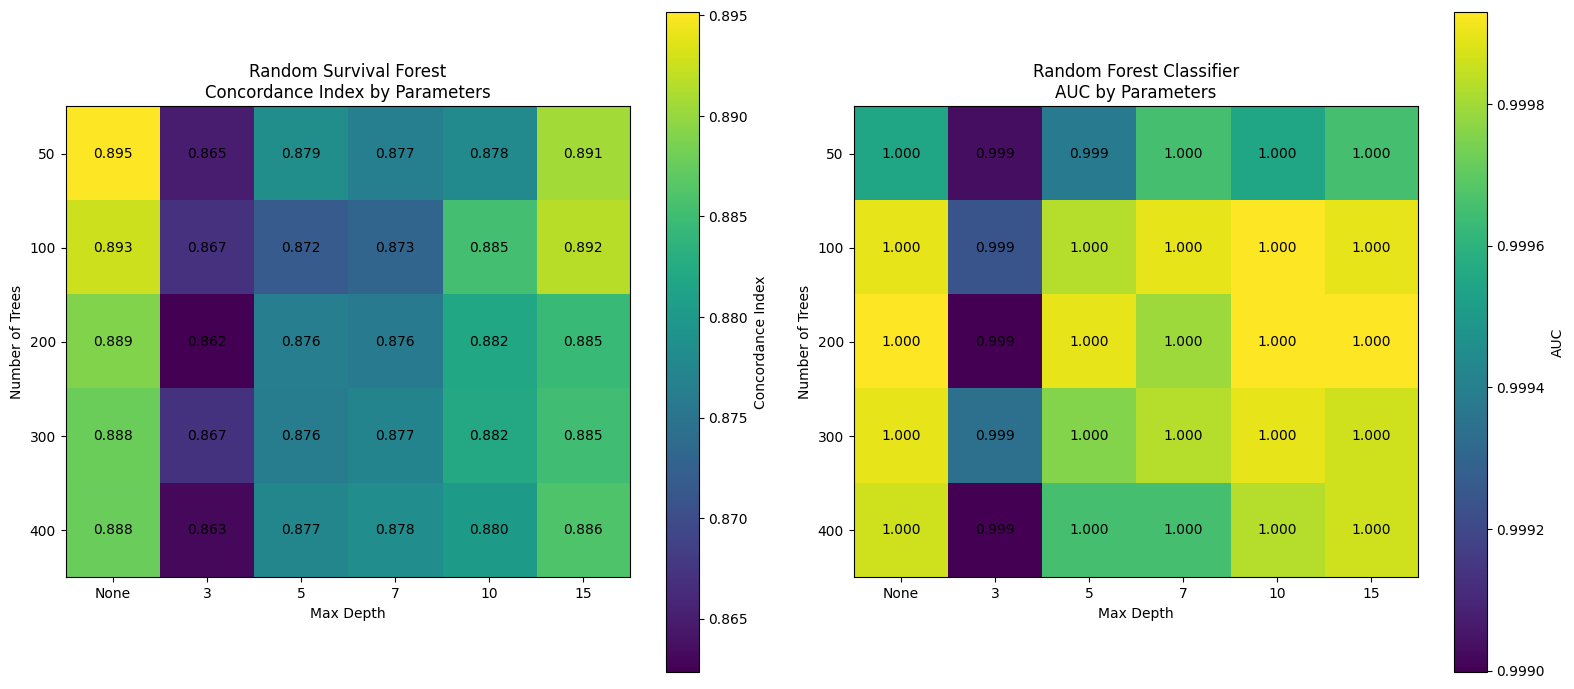

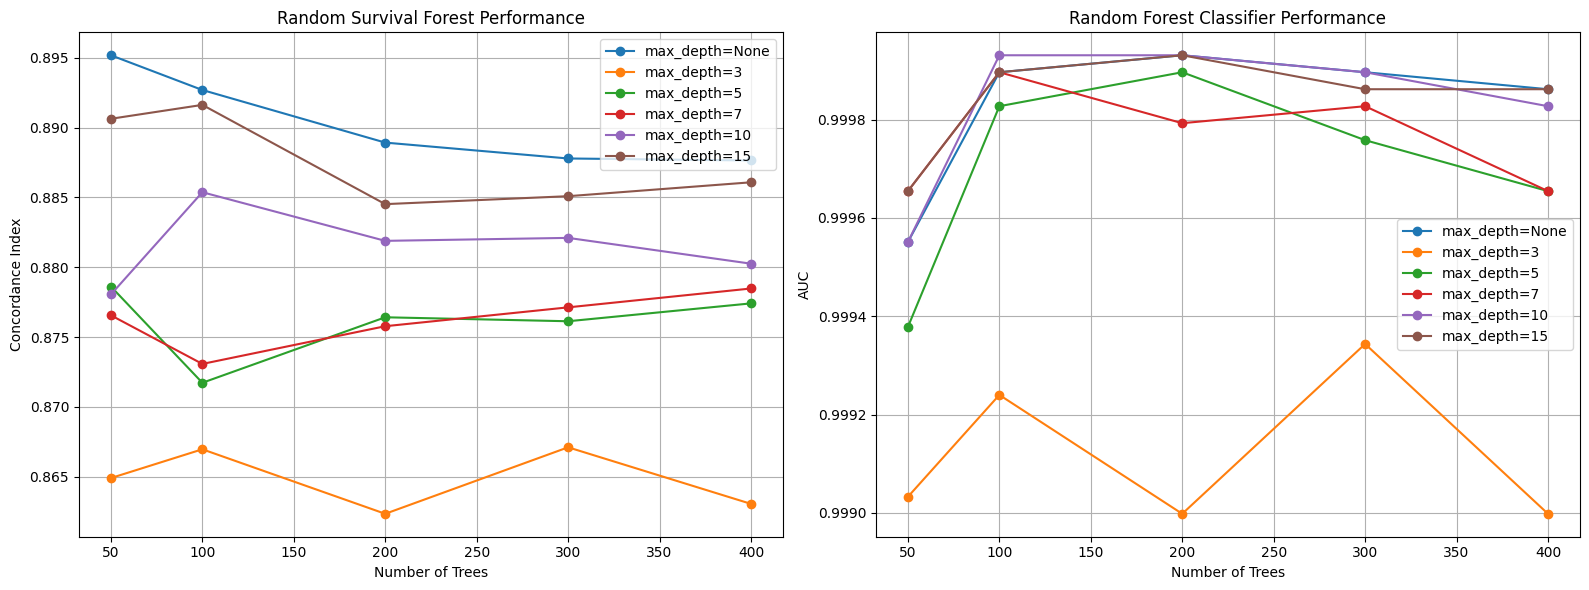

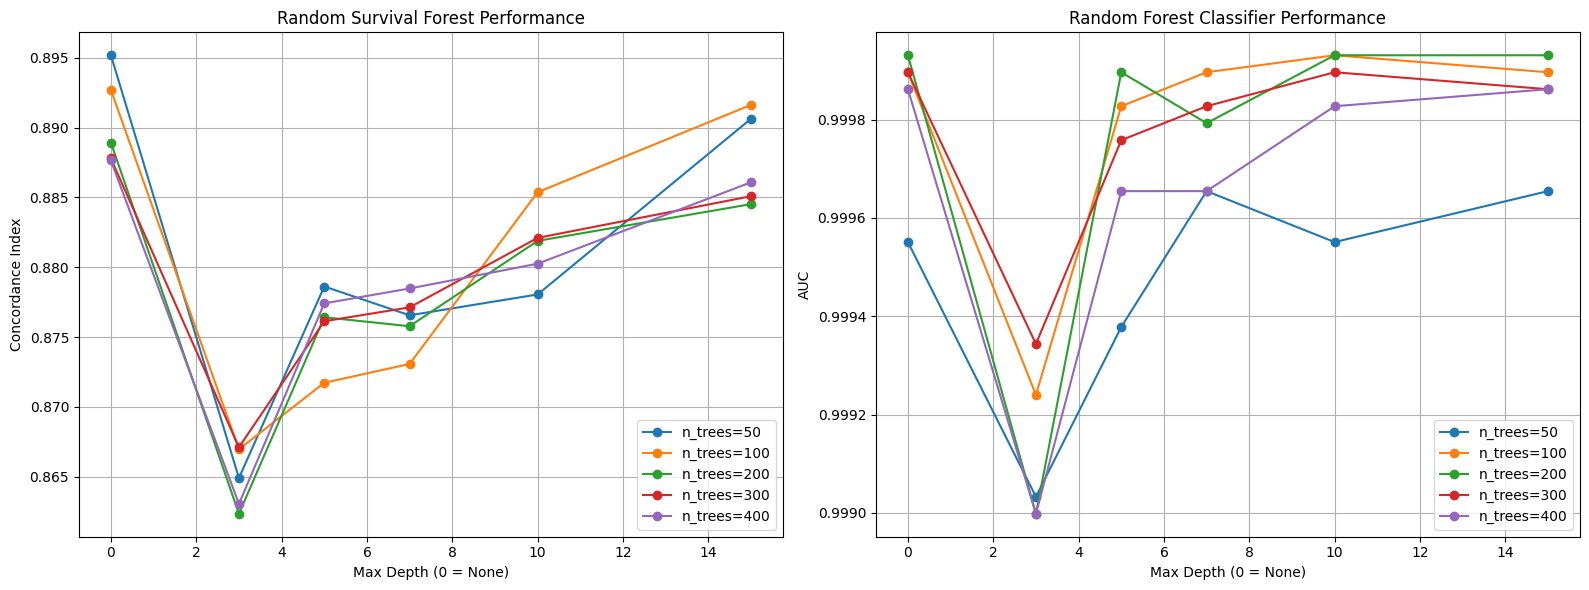


Optimal parameters for Random Survival Forest:
n_estimators = 50
max_depth = None
Best Concordance Index: 0.8952

Optimal parameters for Random Forest Classifier:
n_estimators = 100
max_depth = 10
Best AUC: 0.9999


In [5]:
# Parameter tuning for Random Forest models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Define parameter grids
n_estimators_list = [50, 100, 200, 300, 400]
max_depth_list = [None, 3, 5, 7, 10, 15]

# Dictionaries to store results
survival_results = np.zeros((len(n_estimators_list), len(max_depth_list)))
classification_results = np.zeros((len(n_estimators_list), len(max_depth_list)))

# 1. Parameter tuning for Survival model
print("Tuning Random Survival Forest parameters...")
for i, n_est in enumerate(n_estimators_list):
    for j, depth in enumerate(max_depth_list):
        rsf = RandomSurvivalForest(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
        rsf.fit(X_train_os, y_train_os)
        pred = rsf.predict(X_test_os)
        c_index = concordance_index_censored(y_test_os["event"], y_test_os["time"], pred)
        survival_results[i, j] = c_index[0]
        print(f"n_estimators={n_est}, max_depth={depth}, C-index={c_index[0]:.3f}")

# 2. Parameter tuning for Classification model
print("\nTuning Random Forest Classifier parameters...")
for i, n_est in enumerate(n_estimators_list):
    for j, depth in enumerate(max_depth_list):
        rfc = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=42
        )
        rfc.fit(X_train_met, y_train_met)
        y_pred_proba = rfc.predict_proba(X_test_met)[:, 1]
        auc = roc_auc_score(y_test_met, y_pred_proba)
        classification_results[i, j] = auc
        print(f"n_estimators={n_est}, max_depth={depth}, AUC={auc:.3f}")

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot for Survival Model
im1 = axes[0].imshow(survival_results, cmap='viridis', interpolation='nearest')
axes[0].set_title('Random Survival Forest\nConcordance Index by Parameters')
axes[0].set_xlabel('Max Depth')
axes[0].set_ylabel('Number of Trees')
axes[0].set_xticks(np.arange(len(max_depth_list)))
axes[0].set_yticks(np.arange(len(n_estimators_list)))
axes[0].set_xticklabels([str(d) if d is not None else "None" for d in max_depth_list])
axes[0].set_yticklabels(n_estimators_list)

# Add colorbar
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar1.set_label('Concordance Index')

# Plot for Classification Model
im2 = axes[1].imshow(classification_results, cmap='viridis', interpolation='nearest')
axes[1].set_title('Random Forest Classifier\nAUC by Parameters')
axes[1].set_xlabel('Max Depth')
axes[1].set_ylabel('Number of Trees')
axes[1].set_xticks(np.arange(len(max_depth_list)))
axes[1].set_yticks(np.arange(len(n_estimators_list)))
axes[1].set_xticklabels([str(d) if d is not None else "None" for d in max_depth_list])
axes[1].set_yticklabels(n_estimators_list)

# Add colorbar
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar2.set_label('AUC')

# Add text annotations with values
for i in range(len(n_estimators_list)):
    for j in range(len(max_depth_list)):
        axes[0].text(j, i, f"{survival_results[i, j]:.3f}", 
                     ha="center", va="center", color="white" if survival_results[i, j] < 0.7 else "black")
        axes[1].text(j, i, f"{classification_results[i, j]:.3f}", 
                     ha="center", va="center", color="white" if classification_results[i, j] < 0.7 else "black")

plt.tight_layout()
plt.show()

# Line plots for better interpretation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Line plot for number of trees (n_estimators)
for j, depth in enumerate(max_depth_list):
    depth_label = str(depth) if depth is not None else "None"
    axes[0].plot(n_estimators_list, survival_results[:, j], marker='o', label=f'max_depth={depth_label}')
    axes[1].plot(n_estimators_list, classification_results[:, j], marker='o', label=f'max_depth={depth_label}')

axes[0].set_xlabel('Number of Trees')
axes[0].set_ylabel('Concordance Index')
axes[0].set_title('Random Survival Forest Performance')
axes[0].grid(True)
axes[0].legend()

axes[1].set_xlabel('Number of Trees')
axes[1].set_ylabel('AUC')
axes[1].set_title('Random Forest Classifier Performance')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# Line plot for max_depth
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

max_depth_list_plot = [0 if d is None else d for d in max_depth_list]  # Replace None with 0 for plotting

for i, n_est in enumerate(n_estimators_list):
    axes[0].plot(max_depth_list_plot, survival_results[i, :], marker='o', label=f'n_trees={n_est}')
    axes[1].plot(max_depth_list_plot, classification_results[i, :], marker='o', label=f'n_trees={n_est}')

axes[0].set_xlabel('Max Depth (0 = None)')
axes[0].set_ylabel('Concordance Index')
axes[0].set_title('Random Survival Forest Performance')
axes[0].grid(True)
axes[0].legend()

axes[1].set_xlabel('Max Depth (0 = None)')
axes[1].set_ylabel('AUC')
axes[1].set_title('Random Forest Classifier Performance')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# Find optimal parameters
best_surv_idx = np.unravel_index(np.argmax(survival_results), survival_results.shape)
best_class_idx = np.unravel_index(np.argmax(classification_results), classification_results.shape)

print(f"\nOptimal parameters for Random Survival Forest:")
print(f"n_estimators = {n_estimators_list[best_surv_idx[0]]}")
print(f"max_depth = {max_depth_list[best_surv_idx[1]]}")
print(f"Best Concordance Index: {survival_results[best_surv_idx]:.4f}")

print(f"\nOptimal parameters for Random Forest Classifier:")
print(f"n_estimators = {n_estimators_list[best_class_idx[0]]}")
print(f"max_depth = {max_depth_list[best_class_idx[1]]}")
print(f"Best AUC: {classification_results[best_class_idx]:.4f}")